In [29]:
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import signal
from scipy.optimize import curve_fit
from scipy.signal import find_peaks



#sns.set(style="darkgrid")

In [15]:
# Code used to explore some of the IGETS data
# Data is publically available, see IGETS group website for details

# http://igets.u-strasbg.fr/

In [41]:
def Noise_Gen(tm,amp):
    noise=[]
    time=[]
    for i in range(tm):
        noise.append(np.random.normal(0,amp))
        time.append(i)
    return np.array(time), np.array(noise)

def Sig_Gen(tm,t0,w,amp):
    s=[]
    t=[]
    for i in range(tm):
        s.append(((np.sqrt(2*np.exp(1)))/w)*amp*(i-t0)*np.exp(-(i-t0)**2/(w**2)))
        t.append(i)
    return np.array(t), np.array(s)

def TS_Correlations(time,data,kernel):
    kernel=0.96787*np.sqrt(2)*kernel/np.sum(np.abs(kernel))
    output=[]
    tout=[]
    for i in range(len(data)):
        if i < len(data)-len(kernel):
            output.append(np.correlate(data[i:i+len(kernel)],kernel)[0])
            tout.append(time[int(i+len(kernel)/2)])
    return(tout,output)


def SNR_Filter(xdata,ydata,filter_kernel):
    fitval=[]
    fiterr=[]
    noise=[]
    rs=[]
    signal_quad=[]
    tval=[]

    i=0
    xdat=[i for i in range(len(filter_kernel))]

    for i in range(len(ydata)-len(filter_kernel)):
        tval.append(xdata[i])
        ydat=ydata[i:i+len(filter_kernel)]
        popt,pcov = curve_fit(filter_func,xdat,ydat)

        fitval.append(popt[0])
        fiterr.append(np.sqrt(pcov[0][0]))

        signal_fitted=filter_func(1,popt)

        residuals = ydat-filter_func(1,popt)

        ss_sig=np.sqrt(np.multiply(np.sum(signal_fitted**2),1))*np.sqrt(len(filter_kernel))
        ss_res = np.sqrt(np.sum(residuals**2))
        ss_tot = np.sum((ydat-np.mean(ydat))**2)

        noise.append(ss_res)
        signal_quad.append(ss_sig)

        r_squared = 1-(ss_res / ss_tot)
        rs.append(r_squared)
    return(tval,fitval,fiterr,signal_quad,noise)



def filter_func(t,a):
    return np.multiply(a,kernel)

def gaussian(x,bb,cc,dd):
    hold=bb*np.exp(-1*(x-cc)**2/(2*dd**2))
    return hold


def TS_Correlations_Fast(time,data,kernel_pass):
    output=signal.correlate(data,kernel_pass,mode='valid',method='fft')
    output=np.divide(output,len(kernel_pass)*np.mean(kernel_pass**2))
    return(time[int(len(kernel_pass)/2)-1:-int(len(kernel_pass)/2)],output)


def SNR_Return_Fast(xdata,ydata,ydatafilt,filter_kernel):
    noise=[]
    signal_quad=[]
    tval=[]
    kernelpower=np.sum(filter_kernel**2)
    half_int=int(len(filter_kernel)/2)
    
    signal_quad=np.sqrt(ydatafilt**2*kernelpower)*np.sqrt(len(filter_kernel))
    tval=xdata[half_int-1:len(ydata)-half_int]
    
    for i in range(half_int,len(ydata)-half_int+1):
        signal_fitted=np.multiply(filter_kernel,ydatafilt[i-half_int])
        residuals = ydata[i-half_int:i+half_int]-signal_fitted
        ss_res = np.sqrt(np.sum(residuals**2))
        noise.append(ss_res)


    return(np.array(tval),signal_quad,noise)

def SNR_Peak_Search(times,SNRval, width, threshold):
    peaks, _ = find_peaks(SNR_vec, height=threshold,distance=width*2)
    return(tval[peaks], SNR_vec[peaks])

In [17]:
test_dir="C:\\Users\\Rees\\Desktop\\Grav Test\\Level3\\"
test_files=listdir(test_dir)

all_files=[]
for i in range(len(test_files)):
    holder=listdir(test_dir+test_files[i]+"\\")
    holder=[test_files[i]+"\\"+x for x in holder]
    all_files.append(holder)

tests=np.array(all_files)
all_files=tests.flatten()


In [18]:
# # # This checks the Raw data Visually
res_full=np.array([])
for i in range(len(all_files)):
    cur_file=test_dir+all_files[i]
    with open(cur_file) as f:
        content=f.readlines()
        pdtest=pd.Series(content)
        testt=pdtest.str[15:25][18:-2].str.strip().values.astype(np.float)
        res_fil=(1e-9)*testt
        res_full=np.hstack([res_full,res_fil])

tlen=len(res_full)
t=np.array([i for i in range(tlen)])


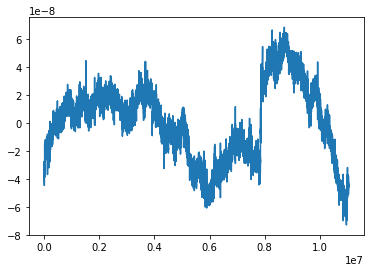

In [36]:
plt.plot(t,res_full)
plt.show()

C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


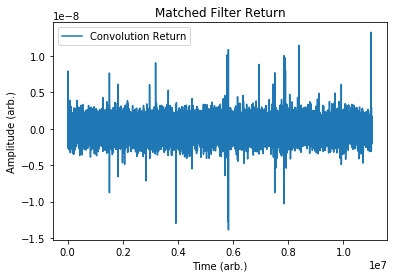

In [52]:
data=res_full

swidth=500
tmask, kernel=Sig_Gen(int(swidth*10),int(swidth*5),swidth,1)
tconv,sigconv=TS_Correlations_Fast(t,data,kernel)

plt.plot(tconv,sigconv,label='Convolution Return')
plt.legend()
plt.xlabel("Time (arb.)")
plt.ylabel("Amplitude (arb.)")
plt.title("Matched Filter Return")
plt.show()

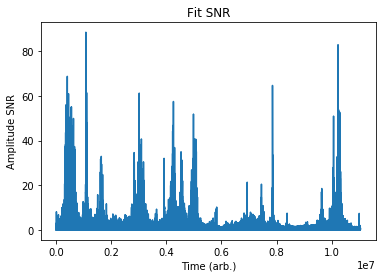

In [53]:
%prun tval,signal_quad,noiseval = SNR_Return_Fast(t,data,sigconv,kernel)
SNR_vec=np.abs(np.divide(signal_quad,noiseval))
plt.plot(tval,SNR_vec)
plt.xlabel("Time (arb.)")
plt.ylabel("Amplitude SNR")
plt.title("Fit SNR")
plt.show()

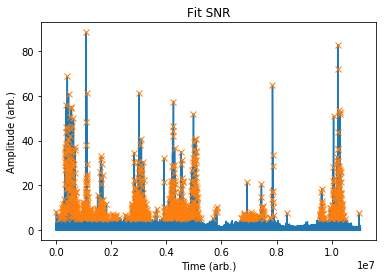

959

In [54]:
# Ican now take the SNR estimator, and return any times where there is a statistically relevant signal (say, and SNR above 5)
# We can then run this series of operations on the data, to see if each sensor sees an event at a similiar time to look 
# for correlations
peaktime,peakval=SNR_Peak_Search(tval,SNR_vec, 2*swidth, 5)

plt.plot(tval,SNR_vec)
plt.plot(peaktime,peakval, "x")
plt.xlabel("Time (arb.)")
plt.ylabel("Amplitude (arb.)")
plt.title("Fit SNR")
plt.show()
len(peaktime)

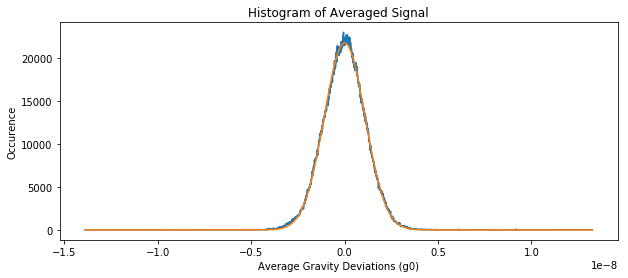

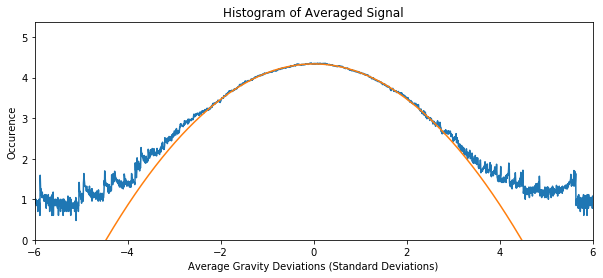

In [55]:
histbins=5000
histy,histx=np.histogram(sigconv,bins=histbins)
histx=histx[:-1]-(histx[0]-histx[1])/2
popt,pcov = curve_fit(gaussian,histx,histy,p0=[max(histy),0,15E-12])

f,ax = plt.subplots(1, figsize=(10,4))
ax.plot(histx,histy)
ax.plot(histx,gaussian(histx,*popt))
ax.set_title("Histogram of Averaged Signal")
plt.xlabel("Average Gravity Deviations (g0)")
plt.ylabel("Occurence")
#plt.xlim([-1E-10,1E-10])
plt.show(f)


f,ax = plt.subplots(1, figsize=(10,4))
ax.plot(np.divide(histx,popt[2]),np.log10(np.add(histy,.00000001)))
ax.plot(np.divide(histx,popt[2]),np.log10(gaussian(histx,*popt)))
ax.set_title("Histogram of Averaged Signal")
plt.xlabel("Average Gravity Deviations (Standard Deviations)")
plt.ylabel("Occurence")
plt.xlim([-6,6])
plt.ylim([0,max(np.log10(np.add(histy,.00001)))+1])
plt.show(f)

C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


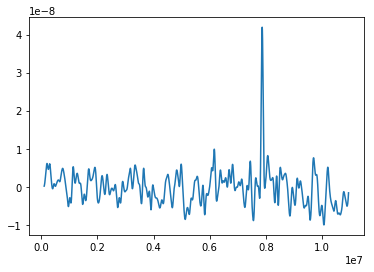

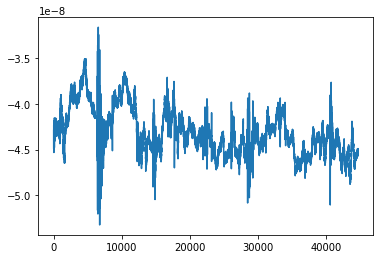

In [14]:
width_vec=[]
max_vec=[]
std_vec=[]
swidth=1

while swidth < 5e4:
    tmask, kernel=Sig_Gen(int(swidth*7),int(swidth*7/2),swidth,1)
    kernel=0.968*np.sqrt(2)*kernel/np.sum(np.abs(kernel))


    tconv,sigconv=TS_Correlations_Fast(t,res_full,kernel)
    max_vec.append(np.max(np.abs(sigconv)))
    std_vec.append(np.std(sigconv))
    width_vec.append(swidth)
    
    swidth=swidth*1.2
    


plt.plot(tconv[2*int(swidth):-2*int(swidth)],sigconv[2*int(swidth):-2*int(swidth)])
plt.show()

plt.plot(res_fil)
plt.show()


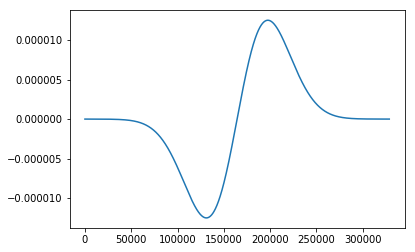

In [15]:
plt.plot(kernel)
plt.show()

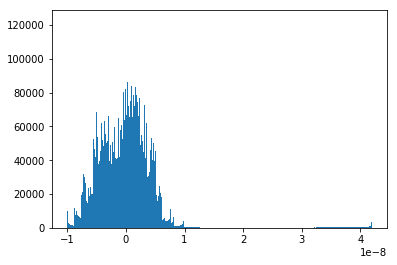

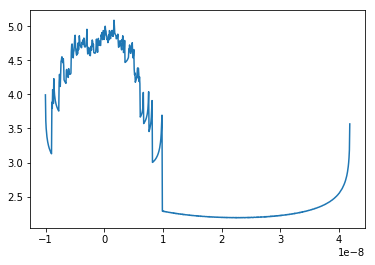

In [16]:
a,b,c=plt.hist(sigconv[2*int(swidth):-2*int(swidth)],bins=800);
plt.show()

plt.plot(b[0:-1],np.log10(a))
plt.show()

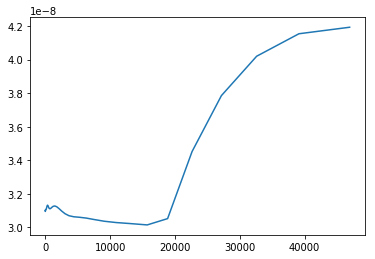

In [17]:
plt.plot(width_vec,max_vec)
plt.show()

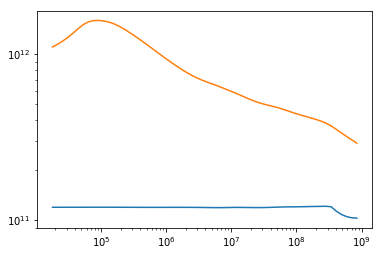

In [18]:
Lambda_Limit=2.1*1e7/np.sqrt(max_vec)
Lambda_Std=2.1*1e7/np.sqrt(std_vec)
dlimit=np.multiply(width_vec,60*300000*1e-3)

plt.loglog(dlimit,Lambda_Limit)
plt.loglog(dlimit,Lambda_Std)
plt.show()